# **PyTorch NumPy Installation**

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from transformers import LlamaConfig, LlamaForCausalLM, LlamaTokenizer
from transformers import ViTConfig, ViTModel

import base64
import io
import pandas as pd
from PIL import Image
from tqdm import tqdm
import random
import numpy as np

In [ ]:
!git clone https://huggingface.co/datasets/uygarkurt/simple-image-captions

fatal: destination path 'simple-image-captions' already exists and is not an empty directory.


----------------------------------------------------------------------------

**BATCH_SIZE: The number of training examples this model process in parallel before updating the weight and bias using gradient descent.**

----------------------------------------------------------------------------

**LEARNING_RATE: The learnning rate is a very small number that denotes that hoow much the modelk will learn and the greadient will update. very lower learning rate may cause the stuck in local minima or local maxima. Again, very high learning rate will expand the global maxima**

----------------------------------------------------------------------------

**EPOCHS: The number of times the model will see the entire dataset during training**

----------------------------------------------------------------------------

**EVAL_INTERVAL: It works as checkpoint and see the performance of the model on validation data.**

----------------------------------------------------------------------------

**N_EMBD: It denotes the width of the model. The input words/pixel will converted in tokens and later on it will converted into embedding matrix. It demonstrates how long the matrix would be.**

----------------------------------------------------------------------------

**N_HEAD: The number of attention heads also known as multi head attentions. It allows the model to focus on 8 different parts of the sequence simulatneously.**

----------------------------------------------------------------------------

**N_LAYER: This is the depth of the model. Besically how many transformer the model contains**

----------------------------------------------------------------------------

**DROPOUT: This means that in every epochs how many or percentage of neurons will be dropped / deactivated to prevent the overfitting. It randomly drops neurons each layers.**

----------------------------------------------------------------------------

**MAX_LENGTH: The number of token in each input sequence**

----------------------------------------------------------------------------

**MAX_POSITION_EMBEDDING: This is the highest capability of the model to handle the sequence length**

----------------------------------------------------------------------------

**IMG_SIZE: The input image size foir both height and width**

----------------------------------------------------------------------------

**PATCH_SIZE: An image will split into same size of several patches looks like 2D matrix.**

----------------------------------------------------------------------------

**RGB_CHANNELS: It denotes how many channels or color will each pixel have. 3 channels denotes RGB, 2 means B&W.**

----------------------------------------------------------------------------

# **Parameter Initialization**

In [ ]:
MAX_POSITION_EMBEDDING = 128
ATTENTION_HEAD = 8
LAYER = 8
DROPOUT = 0.5
IMG_SIZE =  96
LEARNING_RATE = 5e-5
MAX_LENGTH_TOKEN = 16
CHECKPOINTS = 10
EPOCHES = 6
EMBEDDING = 128
IMG_EMBEDDING_DIM = 512
RGB = 3
BATCH_SIZE = 15
HIDDEN_LAYERS = 14
PATCH = 16
SEED = 42

----------------------------------------------------------------------------

**DEVICE: This line automatically GPU if available, if not then CPU. GPU is recommended for any heavy task**

In [ ]:
DEVICE = None
if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'
TOKENIZER = LlamaTokenizer.from_pretrained("NousResearch/Llama-2-7b-chat-hf")
IMAGE = '/content/simple-image-captions/'

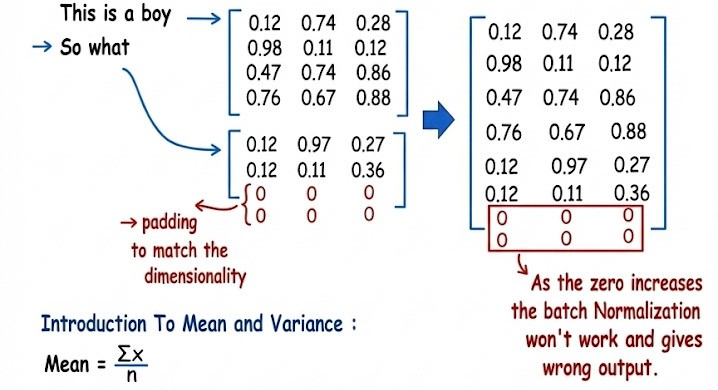

**TOKENIZER.padding_side ensures that the pading will add on the right side to match the dimensionality.**

In [ ]:
TOKENIZER.pad_token = TOKENIZER.eos_token
TOKENIZER.padding_side = "right"

**MAIN GOAL: IMAGE ---------------------------> STRING**

----------------------------------------------------------------------------

**STEP 1: Define a function that convert the image into the string**

**STEP 2: Load the image name and caption into the .csv file**

**STEP 3: Insert the String into the dataset as a new features**

In [ ]:
def ENCODE(FILE_NAME):
    image_path = IMAGE + FILE_NAME
    with open(image_path, 'rb') as img_file:
        b64_str = base64.b64encode(img_file.read()).decode('utf-8')
    return b64_str

df = pd.read_csv('/content/simple-image-captions/inputs.csv', sep=";").dropna(axis=1, how="all")

df['ENCODED_IMAGE'] = df['file'].apply(ENCODE)
df.head()

file                          caption  \
0        car.png                          red car   
1  astronaut.png  astronaut in a white space suit   
2         tv.png      black television on a table   
3      horse.png              brown horse running   
4       wine.png                      wine bottle   

                                       ENCODED_IMAGE  
0  iVBORw0KGgoAAAANSUhEUgAABgAAAAQACAIAAACoEwUVAA...  
1  iVBORw0KGgoAAAANSUhEUgAABAAAAAYACAIAAABn4K39AA...  
2  iVBORw0KGgoAAAANSUhEUgAABgAAAAQACAIAAACoEwUVAA...  
3  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...  
4  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...

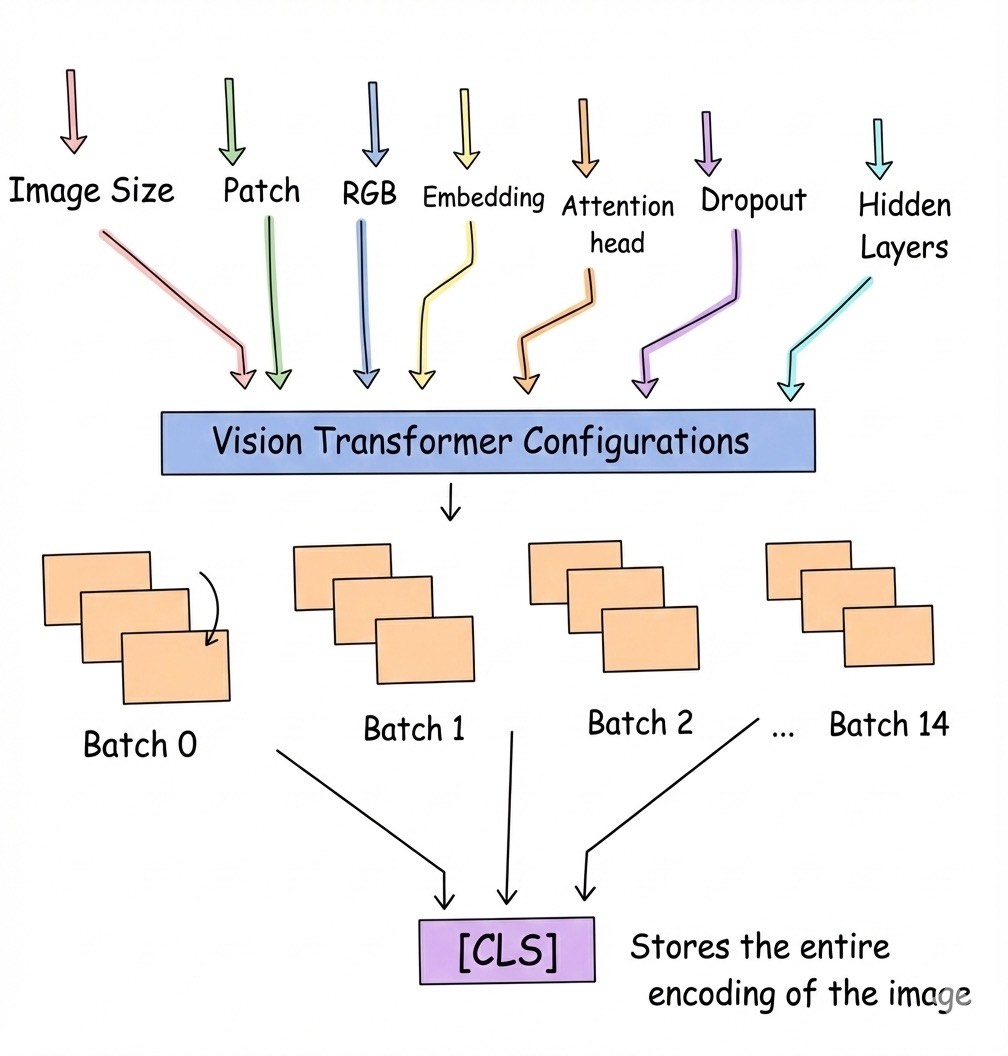

In [ ]:
VISION_TRANSFORMER_CONFIGURATIONS = ViTConfig(
    image_size=IMG_SIZE,
    patch_size=PATCH,
    num_channels=RGB,
    hidden_size=IMG_EMBEDDING_DIM,
    num_attention_heads=ATTENTION_HEAD,
    num_hidden_layers=HIDDEN_LAYERS,
    intermediate_size=4 * IMG_EMBEDDING_DIM,
    hidden_dropout_prob=DROPOUT,
    attention_probs_dropout_prob=DROPOUT,
)
testvit = ViTModel(VISION_TRANSFORMER_CONFIGURATIONS)
INPUT = torch.zeros(BATCH_SIZE, RGB, IMG_SIZE, IMG_SIZE)
CLS = testvit(INPUT).last_hidden_state[:, 0]

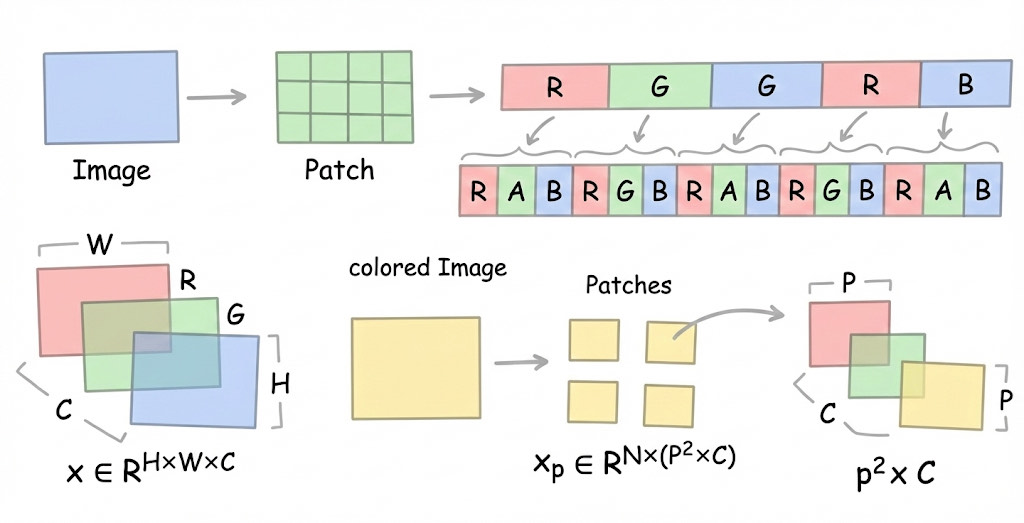

# **Text Embedding**
**Defines the dimensionality of text token vectors and the core hidden size of the language model. It controls how much semantic information each token can represent.**

# **Image Embedding**
**Specifies the vector size of image patch embeddings produced by the ViT. It determines the richness of visual feature representation and multimodal alignment capacity.**

# **Vocabulary Size**
**Represents the total number of unique tokens the model can process. It directly affects embedding tables, output layers, and language coverage.**

# **Layers**
**Indicates the number of stacked transformer blocks in the model. More layers enable deeper reasoning but increase computational cost.**

# **Attention Head**
**Defines the number of attention heads per transformer layer. Multiple heads allow parallel attention to different representation subspaces.**

# **Image Size**
**Sets the spatial resolution of input images before patching. Larger sizes preserve detail but increase patch count and computation.**

# **Hidden Layers (Immediate Size)**
**Controls the width of the feed-forward network inside each transformer block. Typically set to 4× the embedding size to enhance non-linear modeling capacity.**

# **Dropout**
**Specifies the probability of randomly deactivating neurons during training. It improves generalization and reduces overfitting in large models.**

# **Padding ID**
**Identifies the token used to pad text sequences to equal length. It is masked to prevent padding from influencing attention.**

# **Maximum Position Embedding**
**Defines the maximum sequence length supported by positional embeddings. It limits how many text and image tokens can be processed together.**

In [ ]:
class VLM(n.module):
    def __init__(self, text_embedding, image_embedding, vocabulary_size, layers, head, image_size, hidden_layer, dropout, padding_ID, maximum_position_embedding, color_channels):
        super().__init__()
        ViT = ViTConfig(image_size=None, patch_size=None, num_channels=None, hidden_size=None,num_attention_heads=None, num_hidden_layers=None, intermediate_size=None, hidden_dropout_prob=None, attention_probs_dropout_probs=None)
        self.visionEncoder = ViTModel(ViT)
        self.image_projection = nn,linear(image_embedding, text_embedding)
        LangModel = LlamaConfig(vocab_size=None, hidden_size=None, num_hidden_layers=None, num_attention_heads=None, max_position_embeddings=None, pad_token_id=None)
        self.Llama = LlamaForCausalLM(LangModel)
        self.Llama = self.Llama.to(dtype=torch.bfloat16)